In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import time
import numpy as np
from urllib.parse import urlparse
import os
import plotly.express as px
from sklearn.impute import KNNImputer
import calendar
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Base URL of the Met Office historic station data page
base_url = "https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data"

In [3]:

# Function to get the list of station data URLs
def get_station_urls(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    station_links = soup.find_all('a', text='View data')
    urls = [link['href'] for link in station_links]
    return urls

def download_station_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx and 5xx)
        data = response.text.strip()
        return data
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None
# Function to extract filenames from URLs
def extract_filenames(urls):
    filenames = []
    for url in urls:
        parsed_url = urlparse(url)
        filename = os.path.basename(parsed_url.path)
        filenames.append(filename)
    return filenames

def save_text_to_file(text, filename):
    """
    Save the given text to a file.

    Parameters:
    text (str): The text to save.
    filename (str): The name of the file to save the text to.

    """
    try:
        with open(filename, 'w') as file:
            file.write(text)
        print(f"Text successfully saved to {filename}")
    except Exception as e:
        print(f"An error occurred while saving the text to file: {e}")

In [4]:
station_urls = get_station_urls(base_url)
stats_urls = len(station_urls)
filenames = extract_filenames(station_urls)

In [5]:
for station in range(stats_urls):
    data = download_station_data(station_urls[station])
    save_text_to_file(data, filenames[station])
    print("Station data downloaded:", filenames[station])

Text successfully saved to aberporthdata.txt
Station data downloaded: aberporthdata.txt
Text successfully saved to armaghdata.txt
Station data downloaded: armaghdata.txt
Text successfully saved to ballypatrickdata.txt
Station data downloaded: ballypatrickdata.txt
Text successfully saved to bradforddata.txt
Station data downloaded: bradforddata.txt
Text successfully saved to braemardata.txt
Station data downloaded: braemardata.txt
Text successfully saved to cambornedata.txt
Station data downloaded: cambornedata.txt
Text successfully saved to cambridgedata.txt
Station data downloaded: cambridgedata.txt
Text successfully saved to cardiffdata.txt
Station data downloaded: cardiffdata.txt
Text successfully saved to chivenordata.txt
Station data downloaded: chivenordata.txt
Text successfully saved to cwmystwythdata.txt
Station data downloaded: cwmystwythdata.txt
Text successfully saved to dunstaffnagedata.txt
Station data downloaded: dunstaffnagedata.txt
Text successfully saved to durhamdata.

# Data Loading and Cleaning

In [6]:
# Define the columns to be used
columns = ["yyyy", "mm", "tmax", "tmin", "af_days", "rain_mm", "sun_hours"]

names = [x[:-8] for x in filenames]

# Function to clean and parse a line of data
# def clean_line(line):
#     line = line.strip()
#     if "Provisional" in line:
#         line = line.replace("Provisional", "").strip()
#     parts = line.split()
#     if len(parts) == 7:
#         return parts
#     else:
#         return None
def clean_line(line):
    # Remove leading and trailing whitespace
    line = line.strip()
    
    # Remove "Provisional"
    if "Provisional" in line:
        line = line.replace("Provisional", "").strip()
    
    # Remove '*' and '#'
    line = line.replace('*', '').replace('#', '').strip()
    
    # Split the line into parts
    parts = line.split()
    
    # Check if the line has exactly 7 parts
    if len(parts) == 7:
        return parts
    else:
        return None

In [7]:
station_dict = {}
for name in names:
    station_dict[name] = [] 

In [8]:
for filename in filenames:
    # Extract the name from the filename (e.g., 'aberporth' from 'aberporth.txt')
    name = os.path.splitext(filename)[0][:-4]
    
    try:
        # Read the content of the file
        with open(filename, 'r') as file:
            for line in file:
                cleaned_line = clean_line(line)
                if cleaned_line:
                    station_dict[name].append(cleaned_line)
    except FileNotFoundError:
        print(f"File not found: {filename}")

In [9]:
dfs = {}
for name, data in station_dict.items():
    df = pd.DataFrame(data, columns=columns)
    df['sun_hours'] = df['sun_hours'].str.replace('*', '')
    df['af_days'] = df['af_days'].str.replace('*', '')
    df['tmax'] = df['tmax'].str.replace('*', '')
    df['tmin'] = df['tmin'].str.replace('*', '')
    df['rain_mm'] = df['rain_mm'].str.replace('*', '')
    df = df.apply(pd.to_numeric, errors='coerce')
    dfs[name] = df


In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

def impute_missing_values_rf(df, target_column):
    # Split data into rows with missing and non-missing target values
    train_df = df[df[target_column].notnull()]
    test_df = df[df[target_column].isnull()]

    if train_df.empty or test_df.empty:
        print(f"Insufficient data for imputation in column '{target_column}'")
        return df

    # Features and target
    X_train = train_df.drop(columns=[target_column])
    y_train = train_df[target_column]
    X_test = test_df.drop(columns=[target_column])

    # Check for missing values in features
    if X_train.isnull().any().any() or X_test.isnull().any().any():
        print(f"Missing values detected in features for column '{target_column}'")
        return df

    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict missing values
    df.loc[df[target_column].isnull(), target_column] = model.predict(X_test)

    return df

def impute_missing_values_knn(df):
    # Initialize KNNImputer
    imputer = KNNImputer(n_neighbors=1)
    
    # Fit and transform the data
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    
    return df_imputed


# Impute missing values
for key in dfs:
    df = dfs[key]
    print(f"Processing {key}")
    
    # First, use KNN to fill missing values in features
    df = impute_missing_values_knn(df)
    
    # List of columns you want to impute
    columns_to_impute = ['tmax', 'tmin', 'af_days', 'rain_mm', 'sun_hours']

    for col in columns_to_impute:
        if df[col].isnull().any():
            print(f"Imputing missing values in {col} of {key}")
            df = impute_missing_values_rf(df, col)
    
    dfs[key] = df
    print(f"Finished processing {key}")

def check_missing_values(dfs):
    for key, df in dfs.items():
        print(f"Checking missing values for dataset: {key}")
        
        # Total number of missing values
        total_missing = df.isnull().sum().sum()
        print(f"Total missing values: {total_missing}")
        
        if total_missing > 0:
            # Count missing values per column
            missing_per_column = df.isnull().sum()
            print("Missing values per column:")
            print(missing_per_column)
            
            # Optionally, check the percentage of missing values
            missing_percentage = (missing_per_column / len(df)) * 100
            print("Percentage of missing values per column:")
            print(missing_percentage)
        
        print("\n")  # Newline for better readability

# Call the function
check_missing_values(dfs)

def assign_season(month):
    if month in [12, 1, 2]:
        return 1  # Winter
    elif month in [3, 4, 5]:
        return 2  # Spring
    elif month in [6, 7, 8]:
        return 3  # Summer
    elif month in [9, 10, 11]:
        return 4  # Autumn
def calculate_days_in_month(row):
    year = int(row['yyyy'])
    month = int(row['mm'])
    return calendar.monthrange(year, month)[1]

for name, df in dfs.items():
    # Calculate temp_range and avg_tempdf['montly_temp_variation'] = (df['tmax'] - df['tmin'])/ df['tmin']
    df['temp_range'] = df['tmax'] - df['tmin']
    df['avg_temp'] = (df['tmax'] + df['tmin']) / 2
    
    # Convert yyyy and mm to integers if they are strings
    df["yyyy"] = df["yyyy"].astype(int)
    df["mm"] = df["mm"].astype(int)
    
    df['season'] = df['mm'].apply(assign_season)
    df['days_in_month'] = df.apply(calculate_days_in_month, axis=1)
    df['frost_day_props'] = df['af_days'] / df['days_in_month']

    # Update the DataFrame in the dictionary
    dfs[name] = df

def merge_weather_datasets(data_dict, station='station'):
    """
    Combine multiple weather DataFrames into a single DataFrame with an identifier column.

    Parameters:
    - data_dict (dict): Dictionary where keys are station names and values are DataFrames.
    - identifier_column (str): The name of the column to be added to identify the station.

    Returns:
    - pd.DataFrame: A single DataFrame with an identifier column.
    """
    # List to store DataFrames
    combined_dataframes = []
    
    for station_name, df in data_dict.items():
        # Add the station name column
        df[station] = station_name
        combined_dataframes.append(df)
    
    # Concatenate all DataFrames
    combined_df = pd.concat(combined_dataframes, ignore_index=True)
    
    return combined_df

# Combine the weather datasets with 'station' column
combined_df = merge_weather_datasets(dfs, station='station')

from datetime import datetime

def create_date(year, month):
    return datetime(year, month, 1)

combined_df['yyyy'] = combined_df['yyyy'].astype(int)
combined_df['mm'] = combined_df['mm'].astype(int)
combined_df['date'] = [create_date(year, month) for year, month in zip(combined_df['yyyy'], combined_df['mm'])]
combined_df['date'] = combined_df['date'].dt.to_period('M')
combined_df.set_index('date', inplace=True)
combined_df.drop(columns=['yyyy', 'mm'], inplace=True)
combined_df.sort_index(inplace=True)
stations = combined_df['station'].unique()

# Split the DataFrame into a dictionary of DataFrames
station_dfs = {station: combined_df[combined_df['station'] == station] for station in stations}

for station,df in station_dfs.items():
    del df['station']

# Display the DataFrames for each station
for station, df in station_dfs.items():
    print(f"\nData for {station}:\n")
    print(df)


Processing aberporth
Finished processing aberporth
Processing armagh
Finished processing armagh
Processing ballypatrick
Finished processing ballypatrick
Processing bradford
Finished processing bradford
Processing braemar
Finished processing braemar
Processing camborne
Finished processing camborne
Processing cambridge
Finished processing cambridge
Processing cardiff
Finished processing cardiff
Processing chivenor
Finished processing chivenor
Processing cwmystwyth
Finished processing cwmystwyth
Processing dunstaffnage
Finished processing dunstaffnage
Processing durham
Finished processing durham
Processing eastbourne
Finished processing eastbourne
Processing eskdalemuir
Finished processing eskdalemuir
Processing heathrow
Finished processing heathrow
Processing hurn
Finished processing hurn
Processing lerwick
Finished processing lerwick
Processing leuchars
Finished processing leuchars
Processing lowestoft
Finished processing lowestoft
Processing manston
Finished processing manston
Processi

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
import matplotlib.pyplot as plt

# Define functions

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'var{j+1}(t)') for j in range(n_vars)]
        else:
            names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def create_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(LSTM(10))
    model.compile(optimizer='adam', loss='mse')
    return model

def predict_future_values(model, last_known_values, n_months, n_obs):
    input_sequence = last_known_values.reshape((1, n_obs, last_known_values.shape[1]))
    predictions = []
    
    for _ in range(n_months):
        next_pred = model.predict(input_sequence, verbose=0)
        predictions.append(next_pred[0])
        input_sequence = np.roll(input_sequence, shift=-1, axis=1)
        input_sequence[0, -1, :] = next_pred
    
    return np.array(predictions)

def evaluate_and_plot(test_y, predictions, variables, scaler):
    inv_test_predictions = scaler.inverse_transform(predictions)
    inv_test = scaler.inverse_transform(test_y)

    for i in range(inv_test.shape[1]):
        plt.figure(figsize=(15, 30))
        plt.subplot(inv_test.shape[1], 1, i + 1)
        plt.plot(inv_test[:, i], label='Actual')
        plt.plot(inv_test_predictions[:, i], label='Predicted')
        plt.title(variables[i])
        plt.legend()
        
    plt.tight_layout()
    plt.show()

future_predictions_dict = {}
variables = ['tmax', 'tmin', 'af_days', 'rain_mm', 'sun_hours', 'temp_range', 'avg_temp', 'season', 'days_in_month', 'frost_day_props']
n_obs = 10  # Number of time steps

for station_name, df in station_dfs.items():
    print(f"Processing dataset for station: {station_name}")

    # Ensure the index is datetime
    #df.index = pd.to_datetime(df.index, format='%Y %m')
    # Preprocess the data
    df = df[variables]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(df)
    
    # Convert to supervised learning format
    reframed = series_to_supervised(scaled_df, n_obs, 1)
    values = reframed.values
    
    # Split into train and test sets
    n_train_hours = int(len(values) * 0.8)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    
    # Prepare data for LSTM
    train_X = train[:, :n_obs * len(variables)].reshape((train.shape[0], n_obs, len(variables)))
    test_X = test[:, :n_obs * len(variables)].reshape((test.shape[0], n_obs, len(variables)))
    train_y = train[:, -len(variables):]
    test_y = test[:, -len(variables):]
    
    # Create and train the model
    model = create_model((train_X.shape[1], train_X.shape[2]))
    model.fit(train_X, train_y, epochs=50, batch_size=24, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    # Evaluate the model
    predictions = model.predict(test_X)
    mae = mean_absolute_error(test_y, predictions)
    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    print(f"Station: {station_name} - Test MAE: {mae:.3f}, Test RMSE: {rmse:.3f}")
    
    # Predict the next 12 months
    last_known_values = scaled_df[-n_obs:]  # Last n_obs observations
    future_predictions = predict_future_values(model, last_known_values, 12, n_obs)
    
    # Ensure the future predictions have the same number of features as the scaler was trained on
    future_predictions = future_predictions.reshape(-1, len(variables))
    
    # Inverse transform predictions
    future_predictions = scaler.inverse_transform(future_predictions)
    
    current_date = pd.Timestamp.now()
    future_dates = pd.date_range(start=current_date + pd.DateOffset(months=0), periods=12, freq='M').strftime('%Y-%m')
    future_df = pd.DataFrame(future_predictions, index=future_dates, columns=variables)
    
    future_predictions_dict[station_name] = future_df
    print(future_df.head())


Processing dataset for station: armagh
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Station: armagh - Test MAE: 0.066, Test RMSE: 0.096
              tmax       tmin   af_days    rain_mm   sun_hours  temp_range  \
2024-07  18.879278  10.417270  0.019910  65.700607  132.861938    8.424529   
2024-08  18.819571  10.775837  0.076504  79.314697  125.545631    8.140131   
2024-09  16.507517   8.920697  0.254351  71.615448  116.187302    7.673539   
2024-10  12.884164   6.378027  1.735442  79.879730   86.737617    6.652247   
2024-11   9.400853   3.468575  5.328188  72.575333   68.931129    5.937759   

          avg_temp    season  days_in_month  frost_day_props  
2024-07  14.631856  2.987942      30.965246         0.001052  
2024-08  14.888852  3.028472      30.958187         0.001465  
2024-09  12.754418  3.928025      30.109150         0.002465  
2024-10   9.647024  3.977825      30.912855         0.062754  
2024-11   6.426762  3.964722      30.141369         0.175608  
Processing dataset for

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Station: lowestoft - Test MAE: 0.063, Test RMSE: 0.098
              tmax       tmin   af_days    rain_mm   sun_hours  temp_range  \
2024-07  20.296499  12.741619  0.101249  51.513351  197.973328    7.465337   
2024-08  20.726704  13.206017  0.565358  52.398693  191.633820    7.432304   
2024-09  18.271288  11.298956  0.388555  55.126133  138.894760    6.840560   
2024-10  14.377713   8.289392  0.503208  57.402153  103.825027    5.780337   
2024-11   9.704583   4.690660  2.388615  64.904762   60.135929    5.168751   

          avg_temp    season  days_in_month  frost_day_props  
2024-07  16.417208  2.960306      30.940651         0.005419  
2024-08  16.913765  2.957864      30.982286         0.010028  
2024-09  14.890203  3.953563      29.859781         0.020018  
2024-10  11.549718  3.978323      30.847725         0.017942  
2024-11   7.232460  3.978606      29.980358         0.077497  
Processing dataset for station: wickairport
9/9 ━━━━━━━━━━━━

              tmax       tmin   af_days    rain_mm   sun_hours  temp_range  \
2024-07  18.273535  12.110605 -0.143747  60.453285  195.260071    5.779233   
2024-08  18.456921  12.619069 -0.115901  67.622162  186.878464    5.756408   
2024-09  17.450712  11.292280  0.133774  81.757904  146.681320    5.710377   
2024-10  14.684195   9.207512  0.157196  91.551178  119.526436    5.022640   
2024-11  11.322631   6.460514  0.841793  94.534012   72.926994    4.545166   

          avg_temp    season  days_in_month  frost_day_props  
2024-07  15.097245  3.037456      30.907951        -0.001933  
2024-08  15.406405  2.892092      30.950855        -0.000082  
2024-09  14.096189  3.911741      30.163082         0.005725  
2024-10  11.362232  3.989395      30.869488         0.007621  
2024-11   8.461649  3.955922      30.222893         0.025955  
Processing dataset for station: shawbury
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Station: shawbury - Test MAE: 0.067, Test RMSE: 0.097
              tmax  

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Station: eastbourne - Test MAE: 0.068, Test RMSE: 0.100
              tmax       tmin   af_days    rain_mm   sun_hours  temp_range  \
2024-07  20.750755  14.335647 -0.005315  49.282917  258.795685    6.078387   
2024-08  21.335482  14.691978 -0.188221  56.704731  243.201935    6.134530   
2024-09  20.170055  13.262629 -0.096406  63.830196  200.409058    6.131951   
2024-10  17.050541  10.900047  0.127325  89.675316  150.198196    5.559727   
2024-11  13.025274   7.419514  0.671437  93.239792   98.033524    5.101356   

          avg_temp    season  days_in_month  frost_day_props  
2024-07  17.368469  3.133868      30.836510         0.001948  
2024-08  17.738569  3.052071      30.985538         0.006424  
2024-09  16.890697  3.940242      30.046097         0.003687  
2024-10  14.233954  3.973177      30.869122        -0.009091  
2024-11  10.185201  3.954436      30.099617         0.028110  
Processing dataset for station: braemar
5/5 ━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Station: dunstaffnage - Test MAE: 0.076, Test RMSE: 0.109
              tmax       tmin   af_days     rain_mm   sun_hours  temp_range  \
2024-07  17.672535  10.820368  0.006447  113.357979  135.137817    6.701340   
2024-08  17.677860  11.175800  0.071985  121.164864  132.530334    6.482227   
2024-09  15.656488   9.773790  0.201519  161.930435   98.470634    5.984664   
2024-10  12.806792   7.056289  0.699731  185.118423   69.634407    5.342854   
2024-11   9.591738   4.616285  3.158388  178.350388   49.896954    5.043520   

          avg_temp    season  days_in_month  frost_day_props  
2024-07  14.451990  3.039287      30.795204        -0.003391  
2024-08  14.369427  3.051024      30.810699        -0.004242  
2024-09  12.696917  3.900590      30.199888         0.007827  
2024-10  10.006367  3.985367      30.839638         0.026425  
2024-11   6.984058  3.940113      30.095623         0.102925  
Processing dataset for station: whitby
4/4 ━━━━━━━

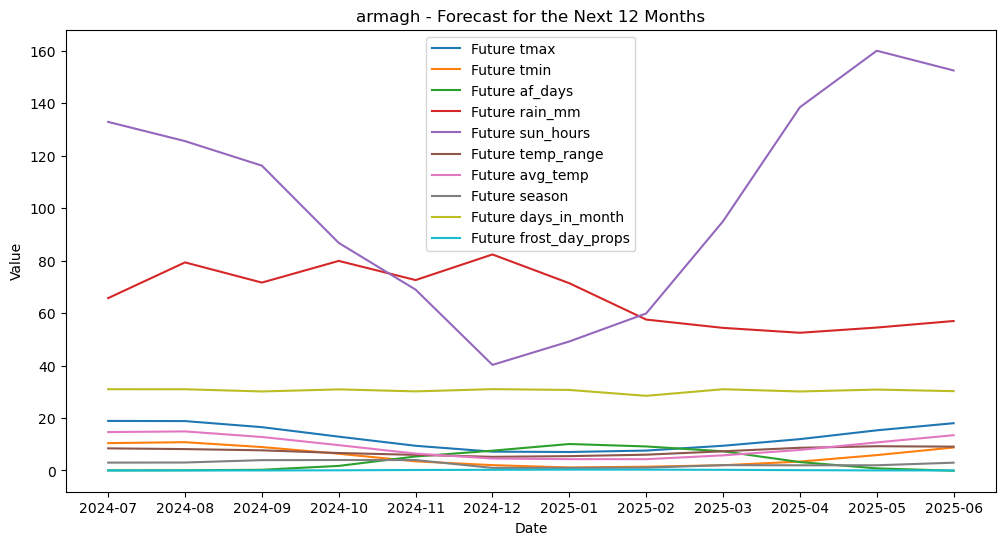

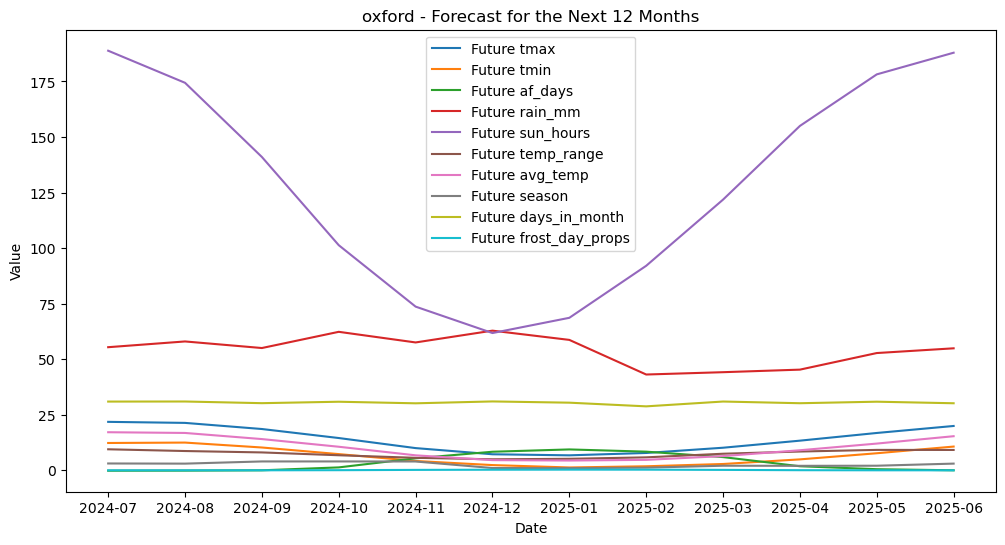

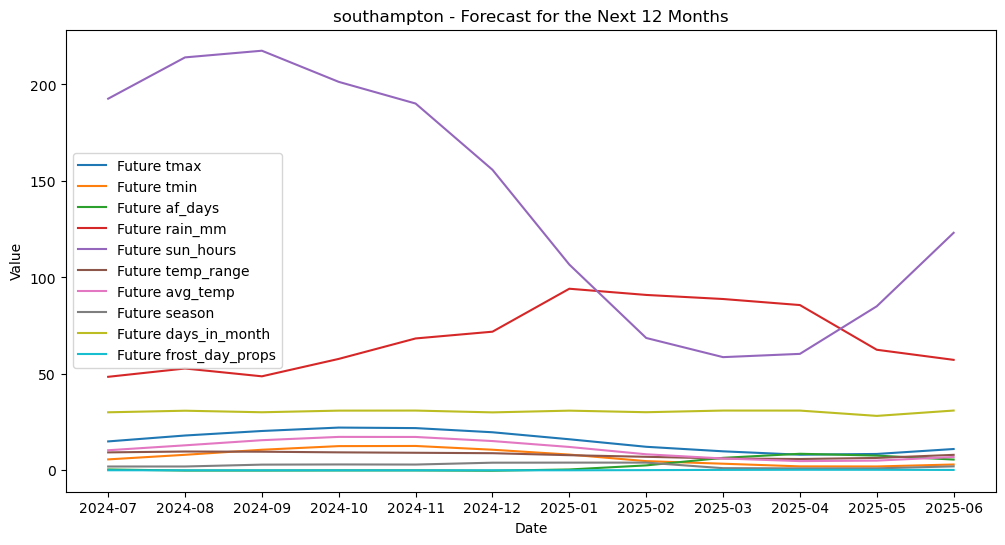

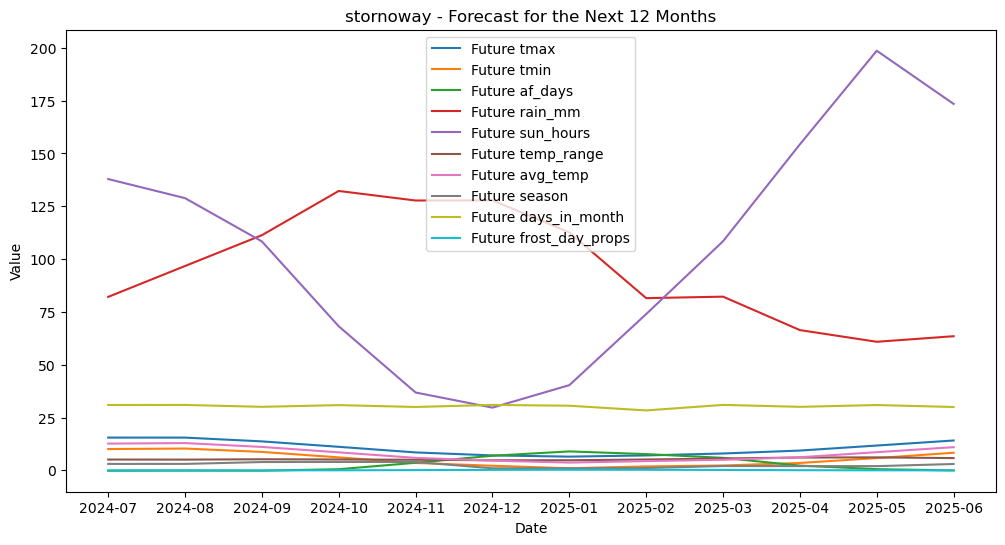

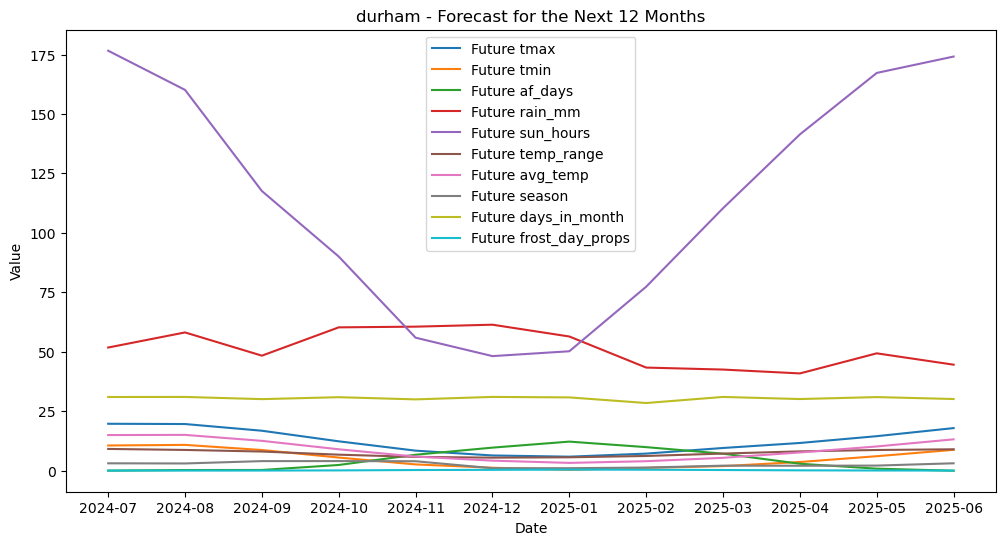

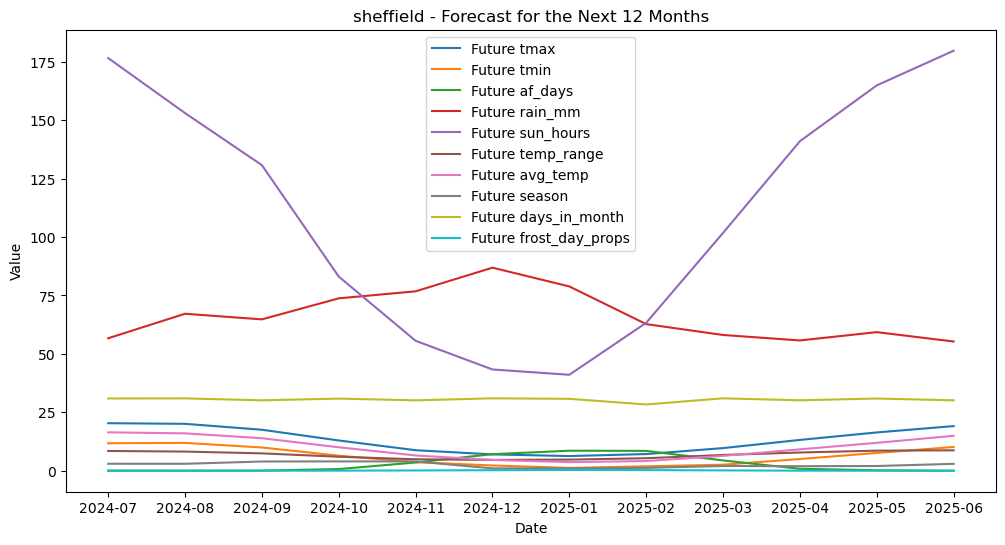

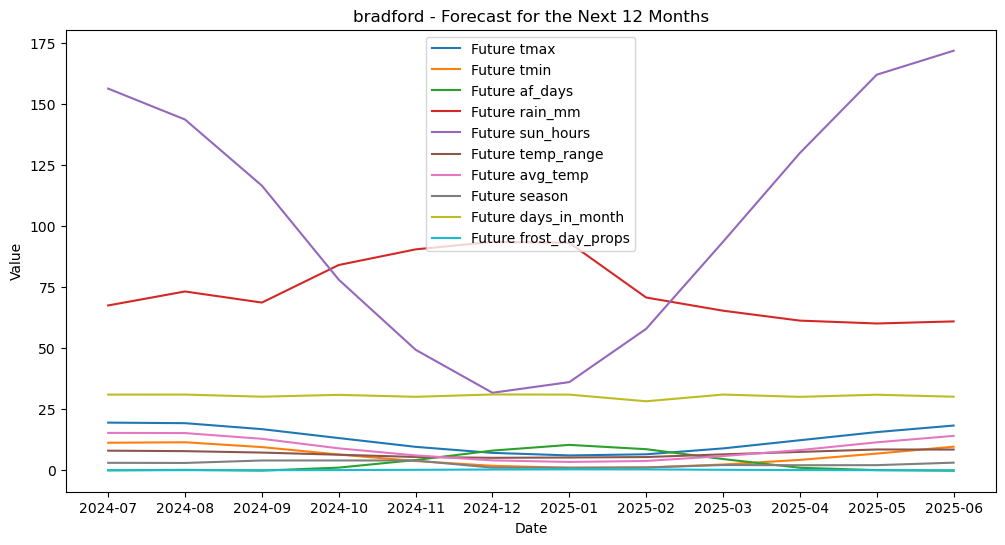

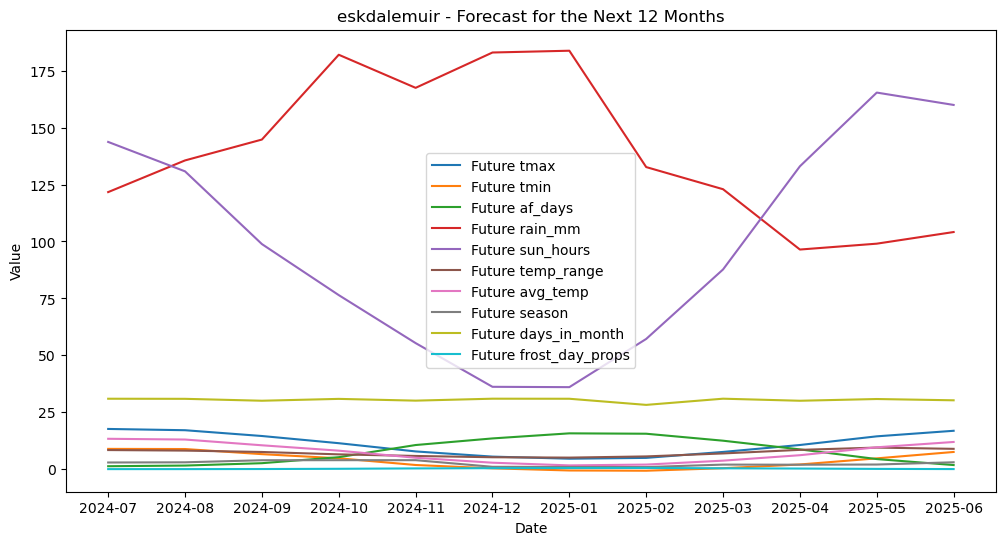

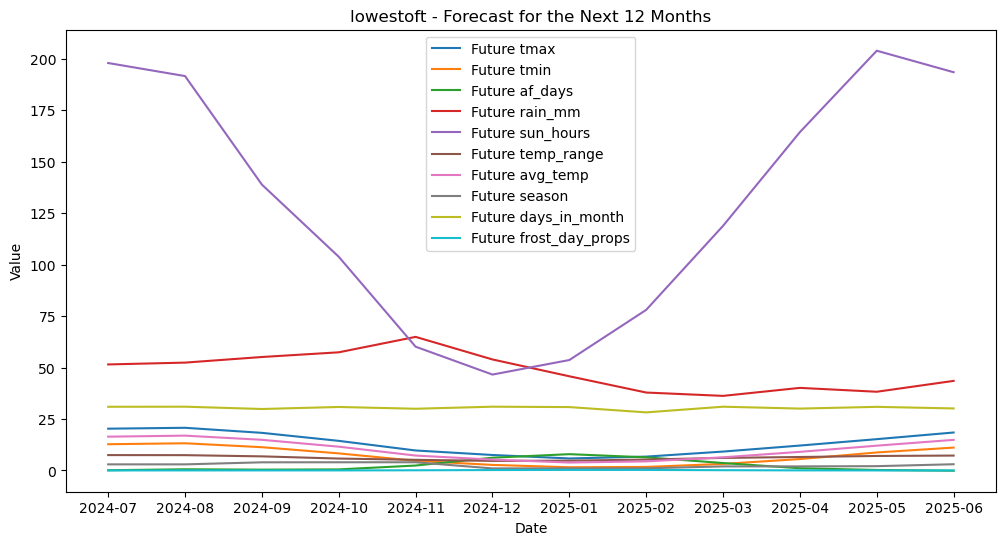

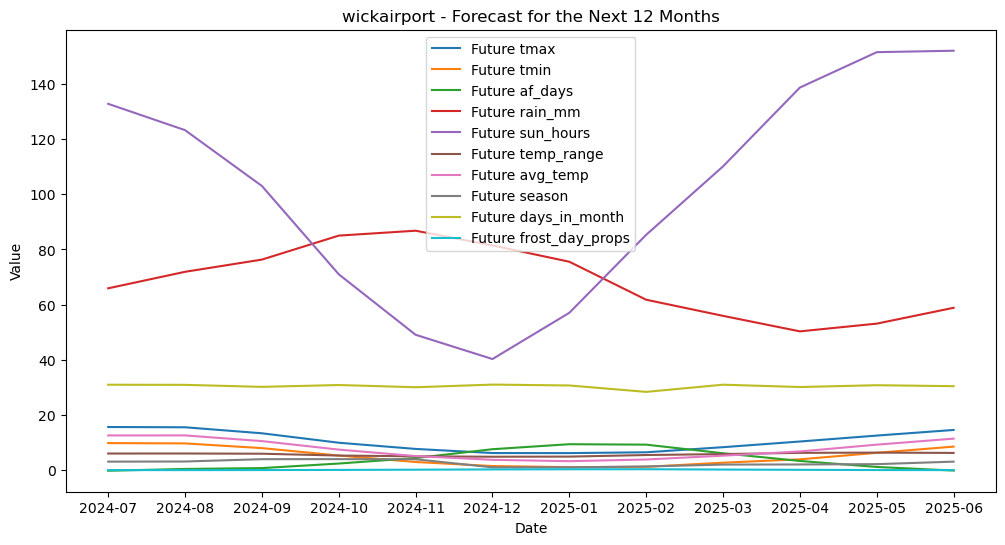

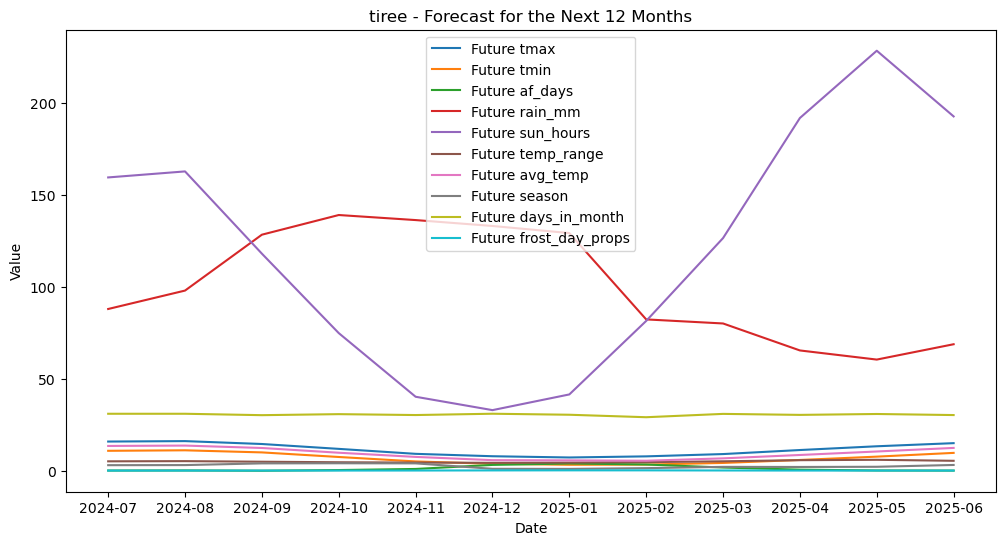

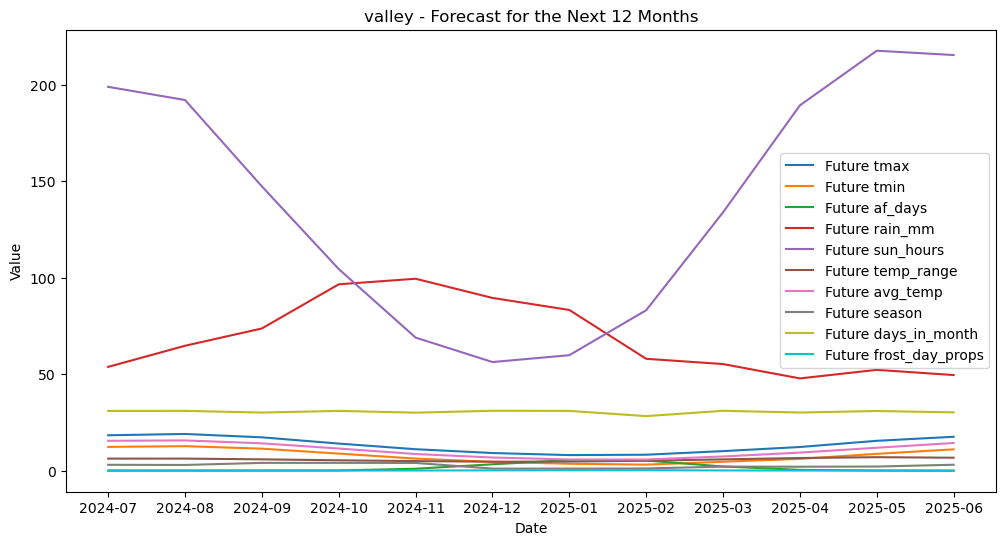

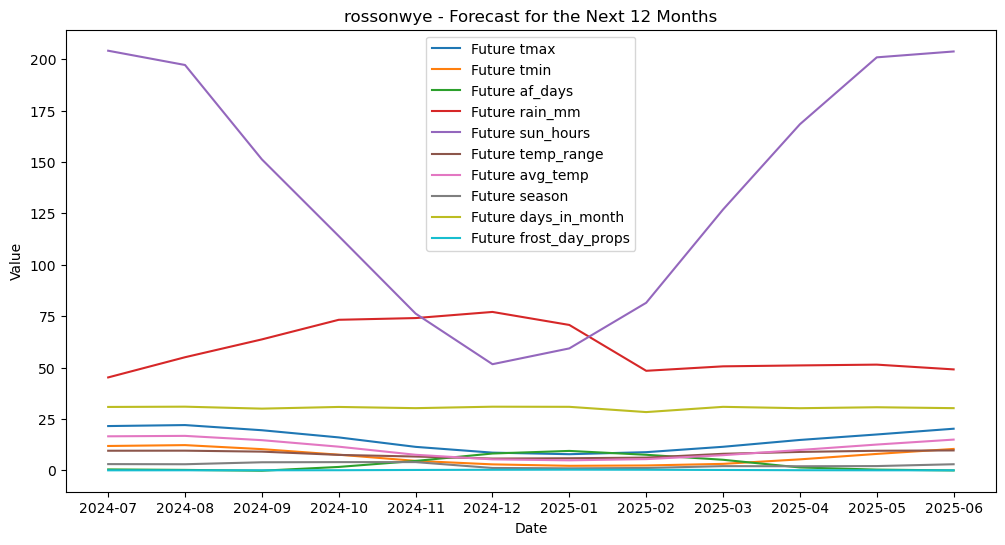

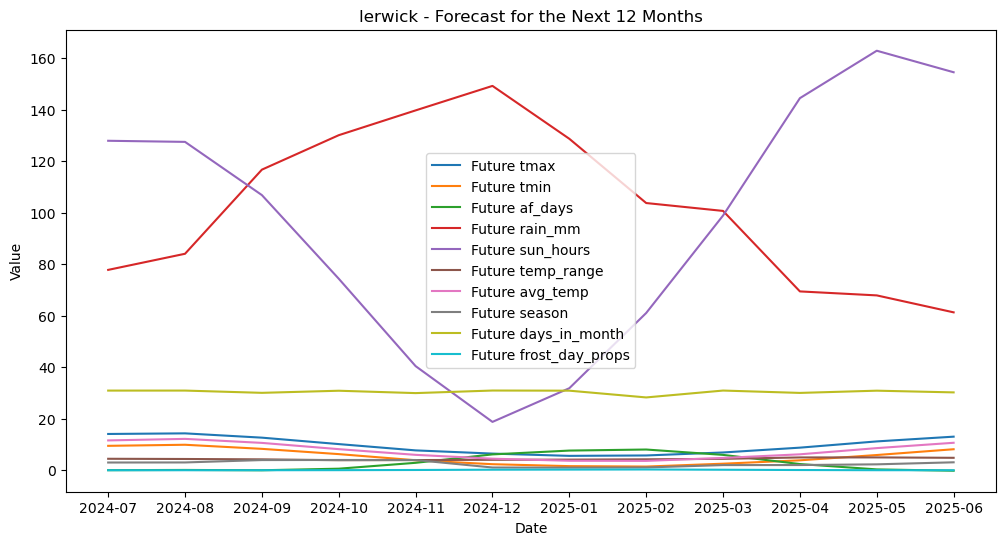

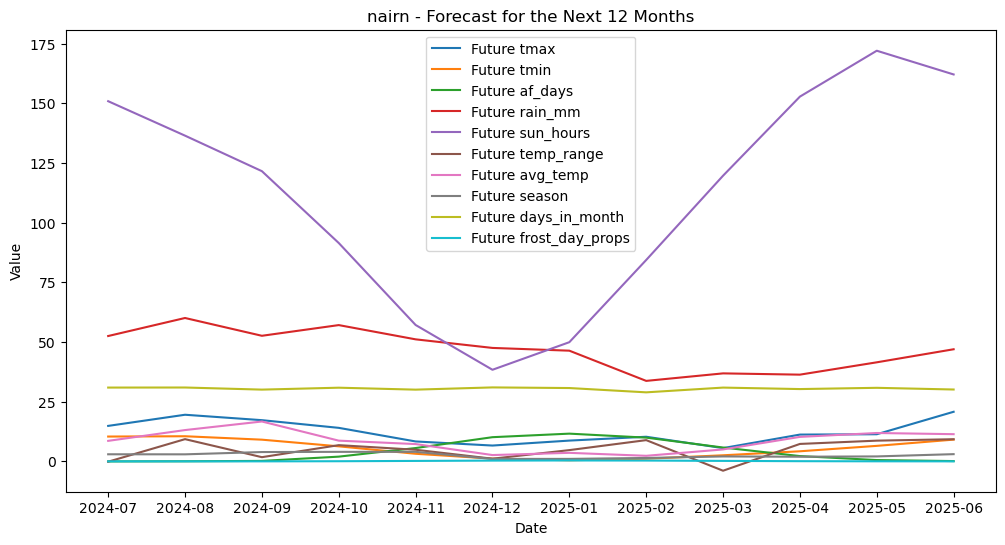

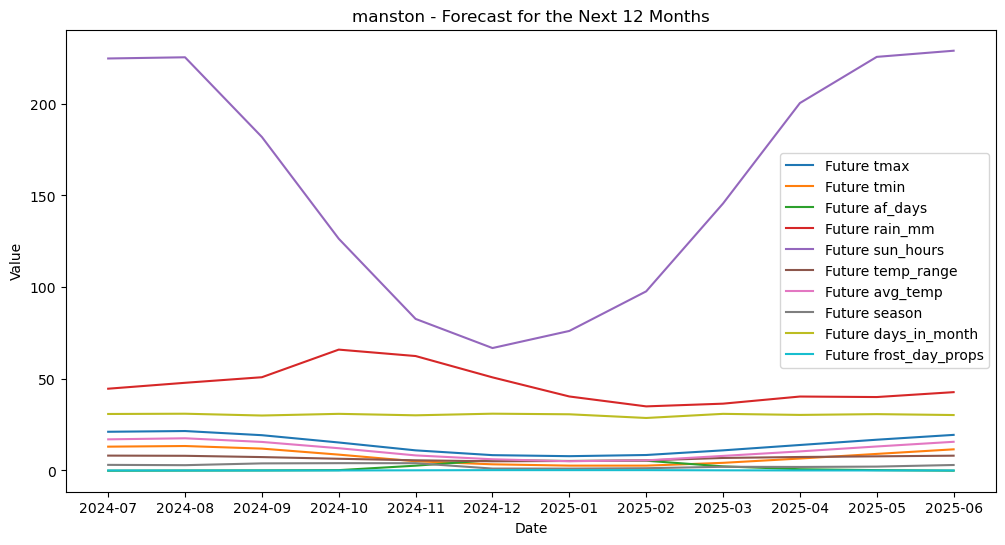

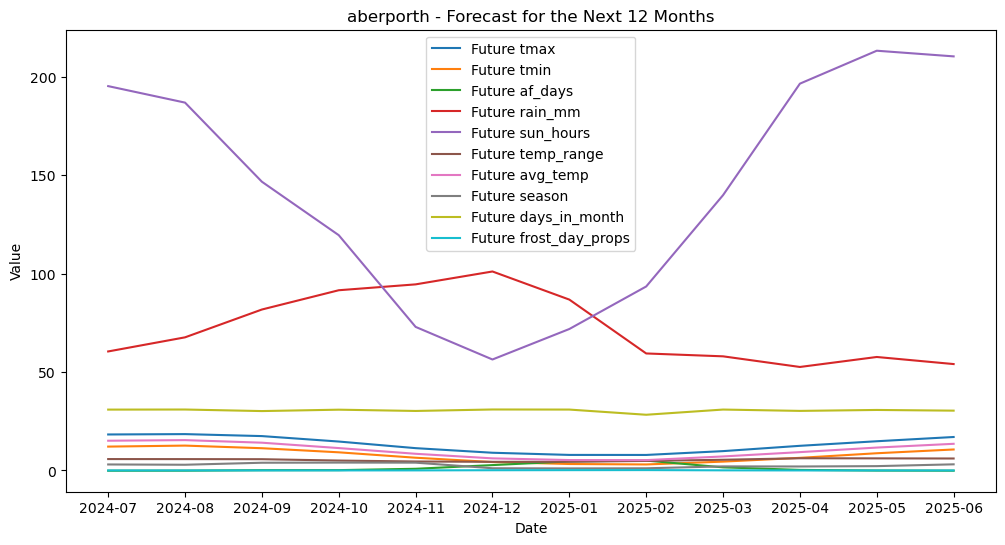

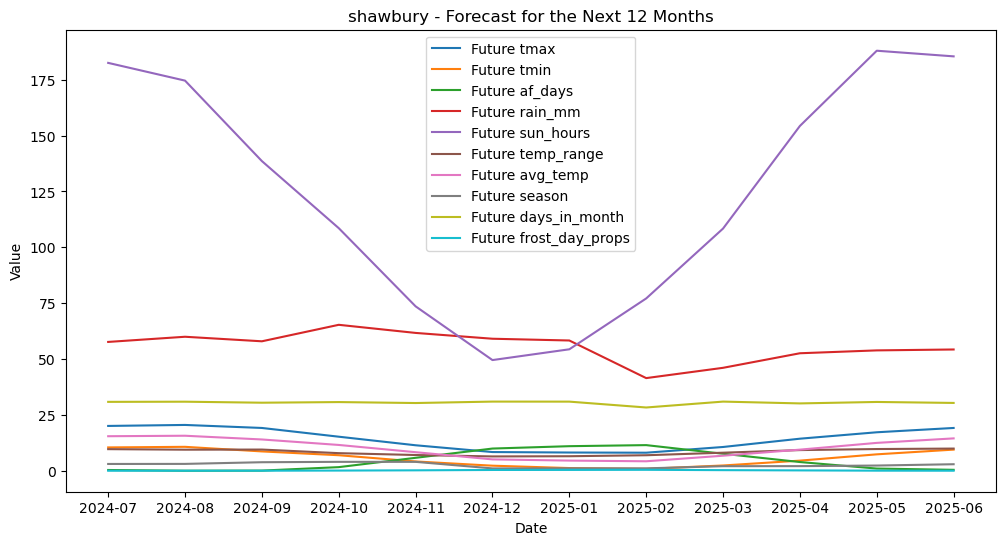

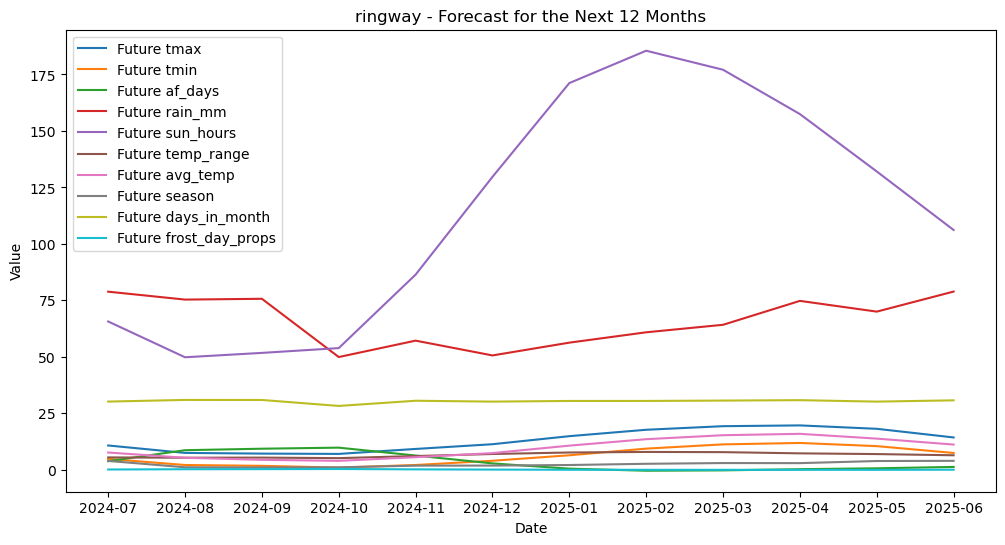

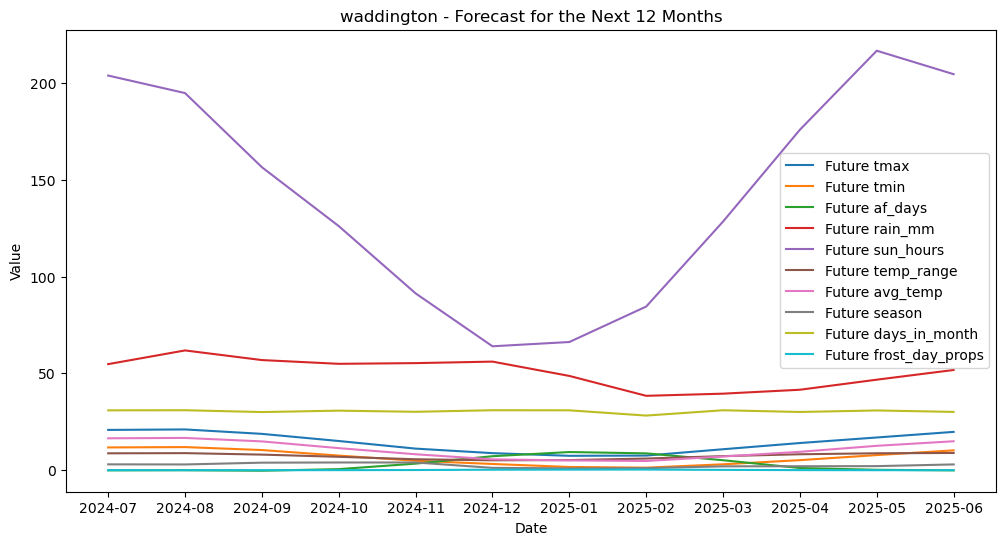

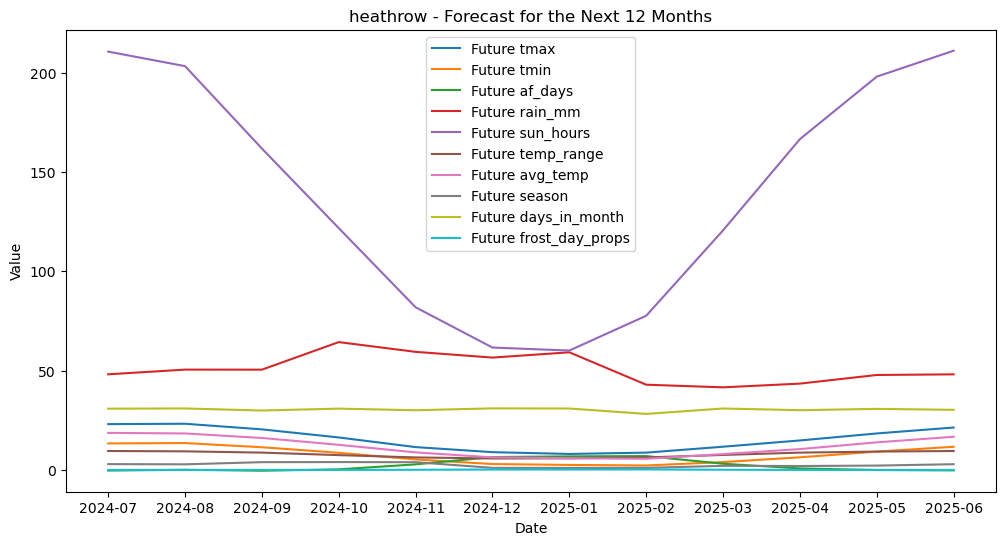

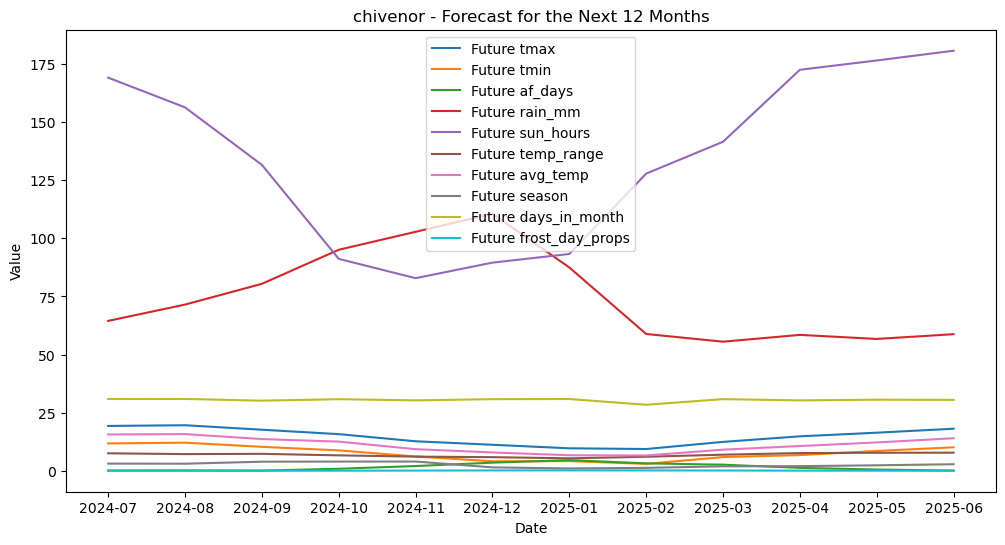

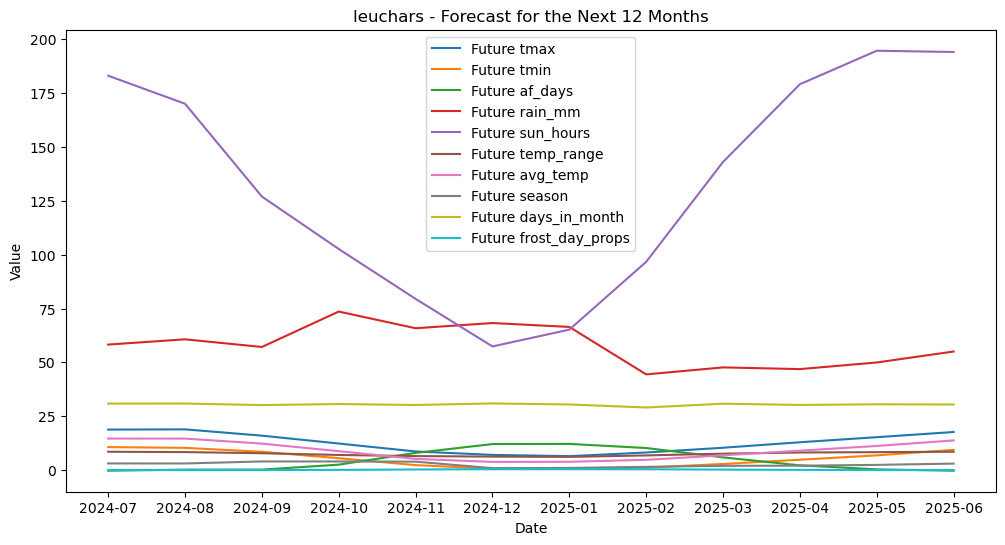

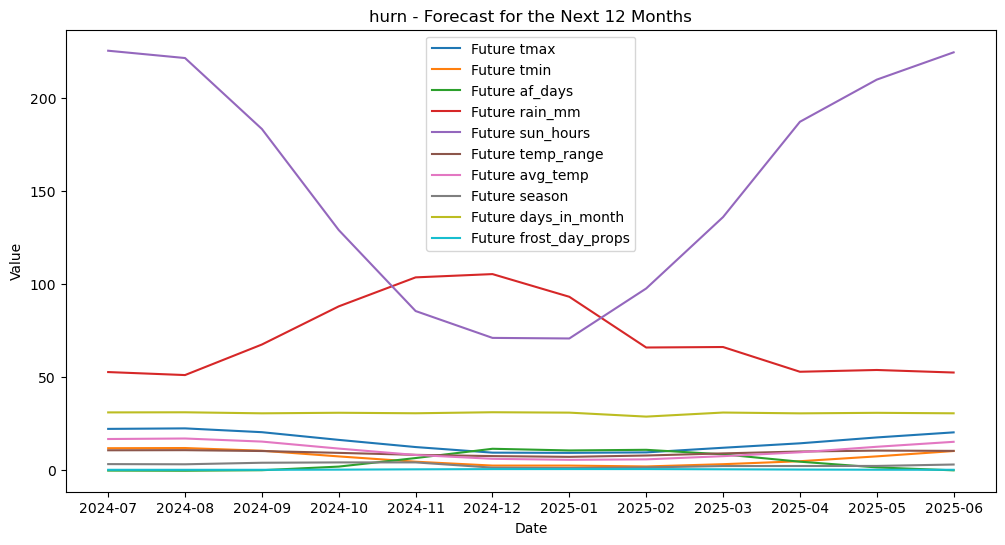

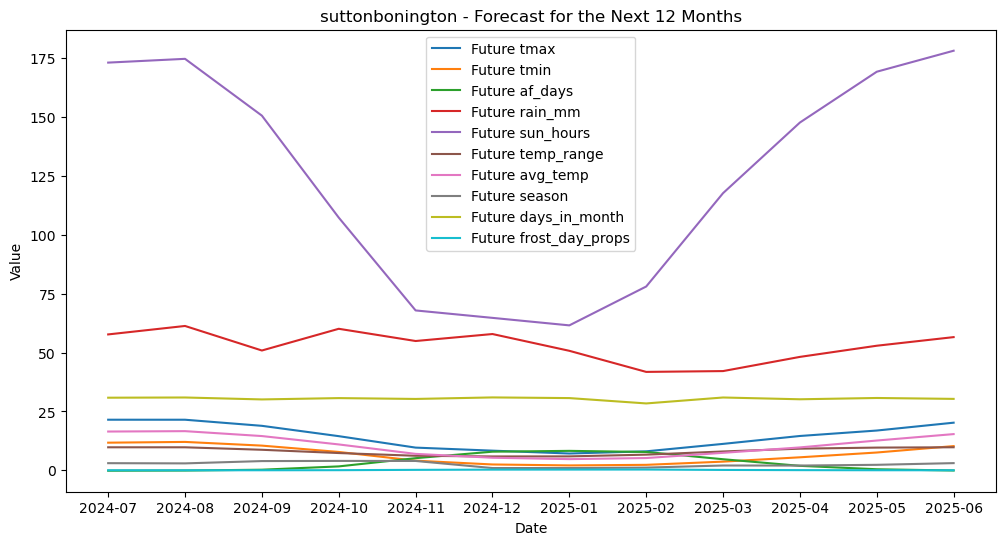

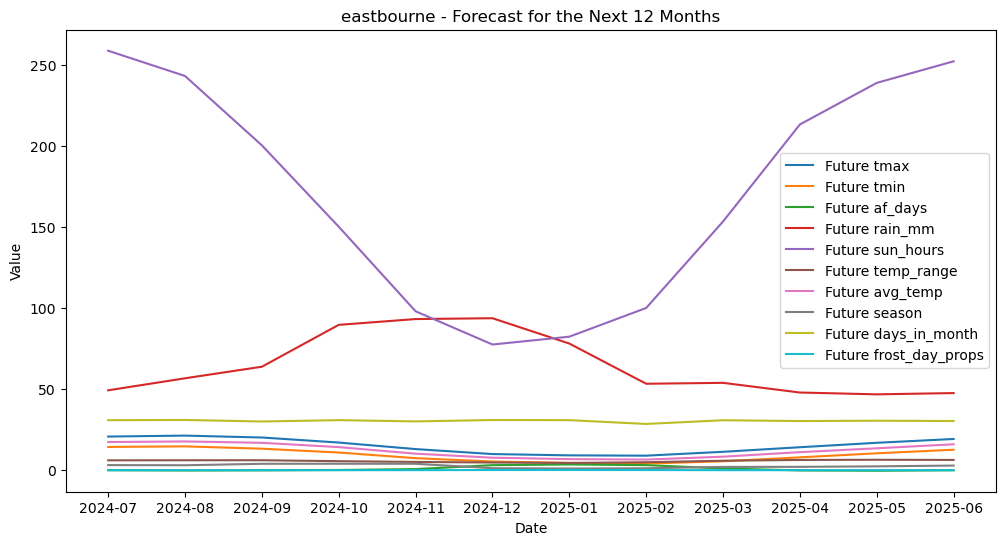

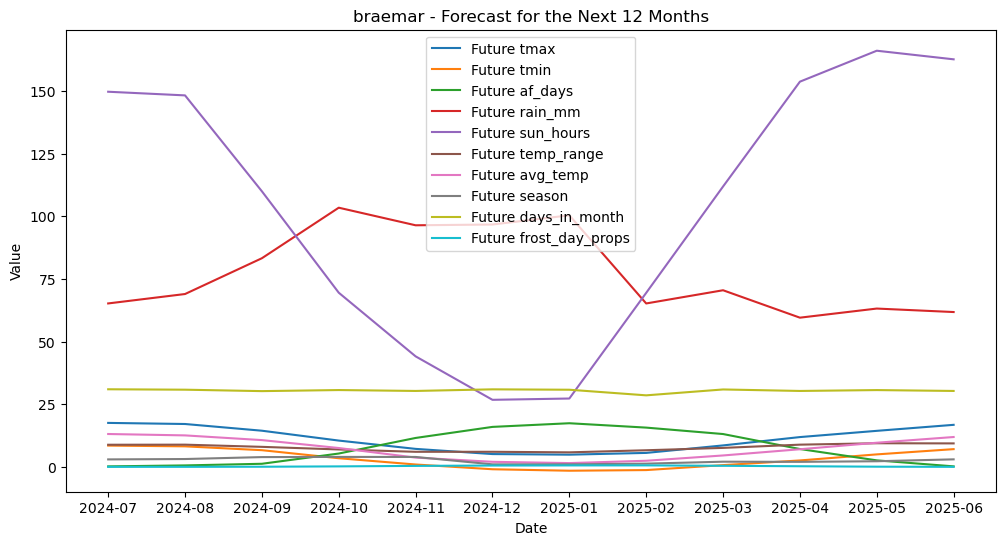

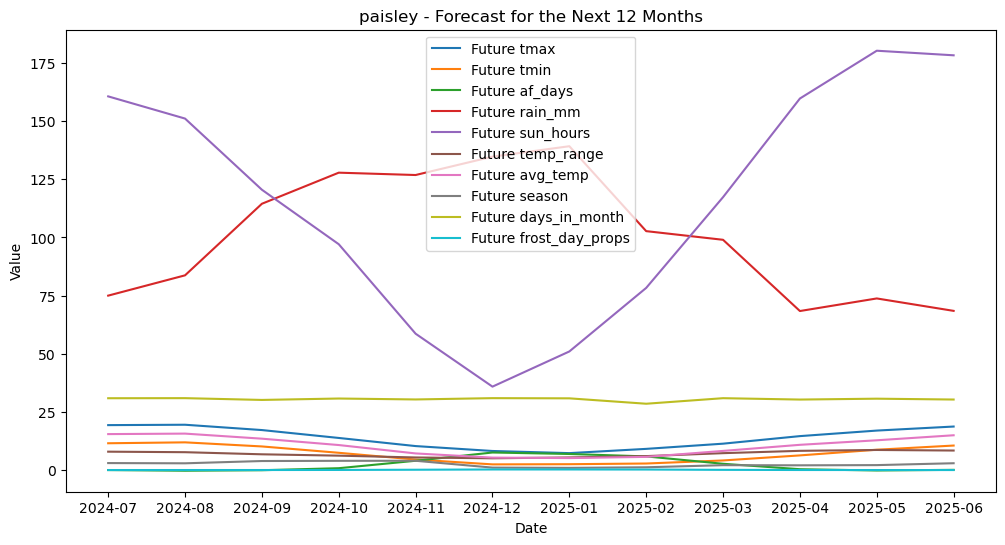

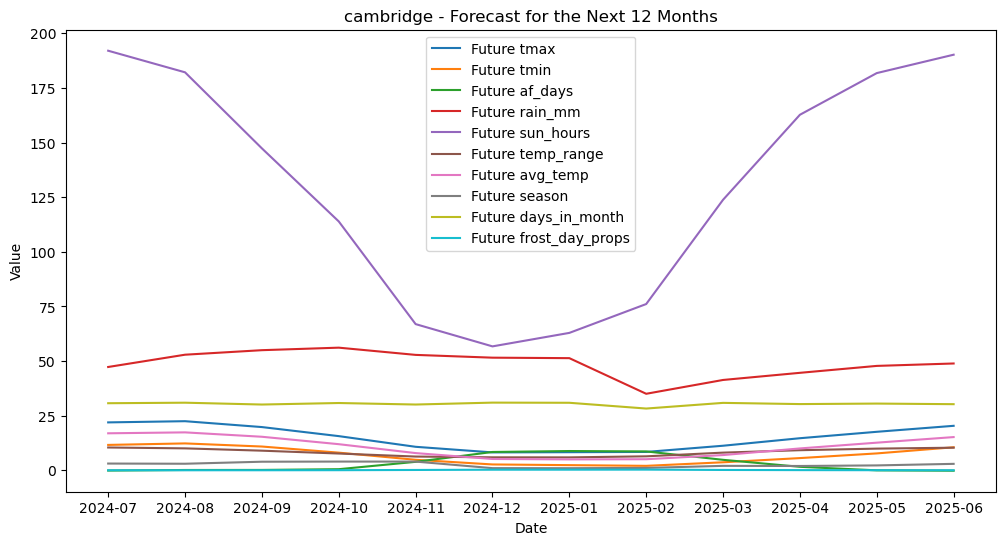

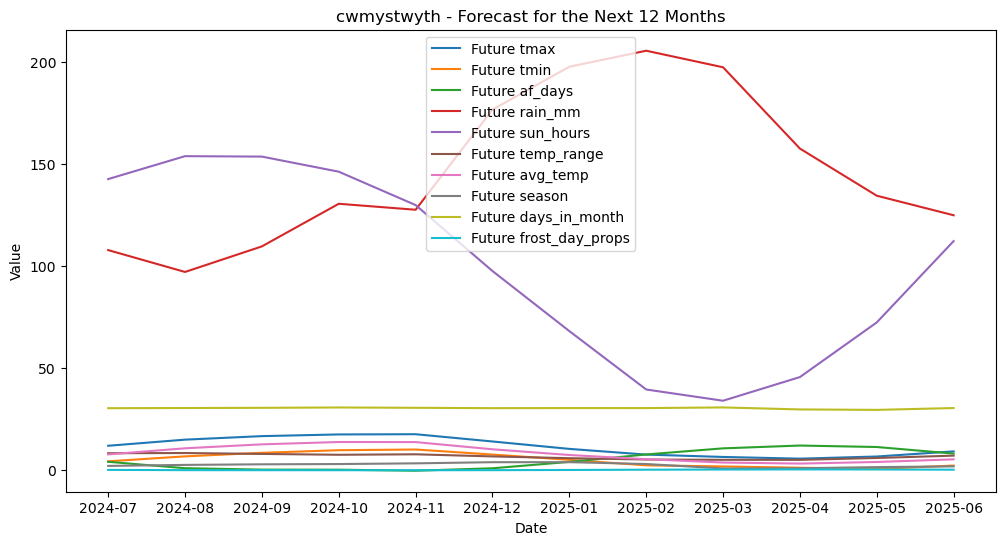

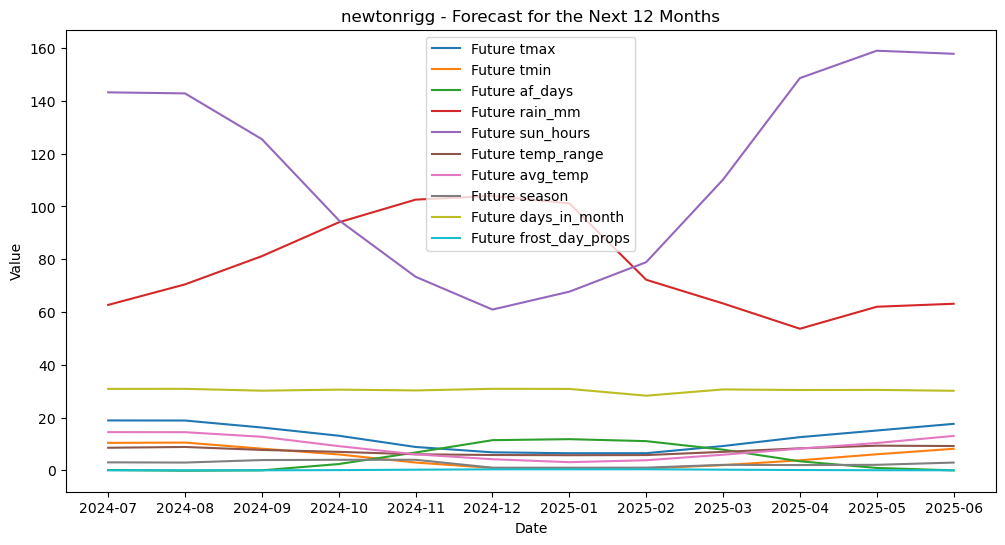

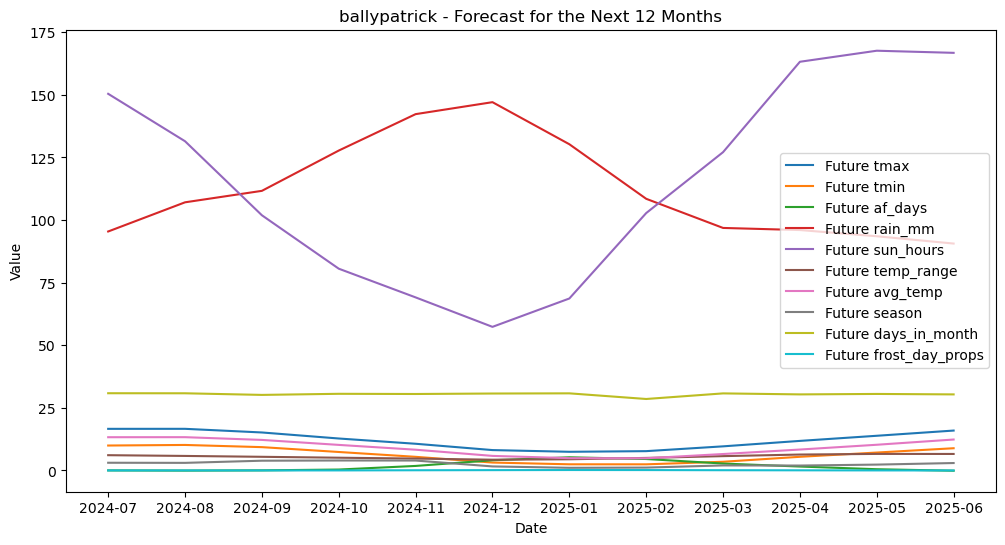

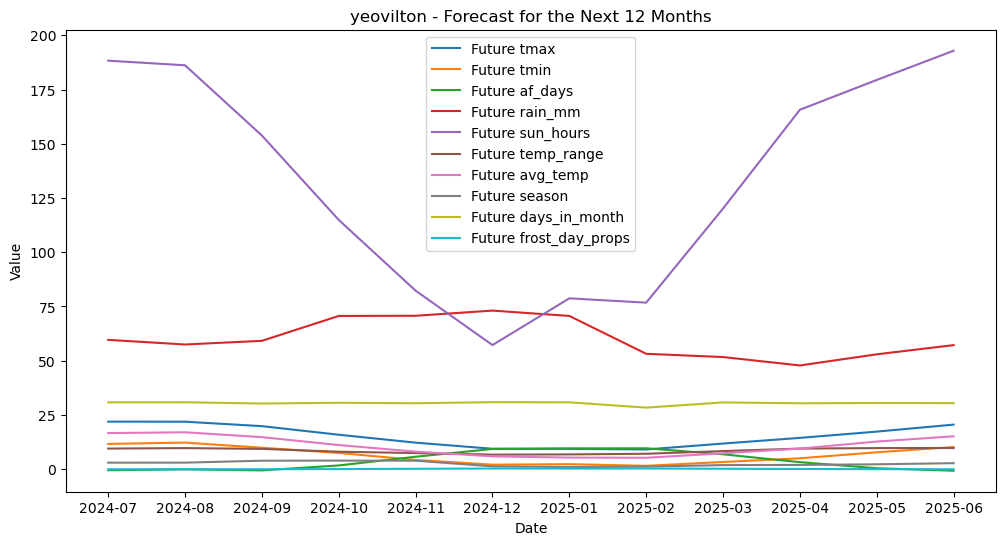

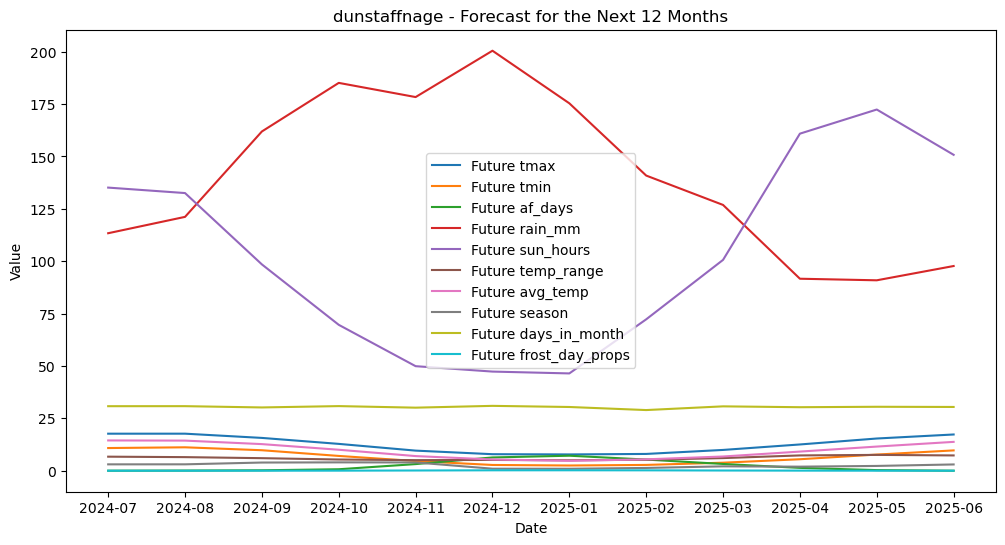

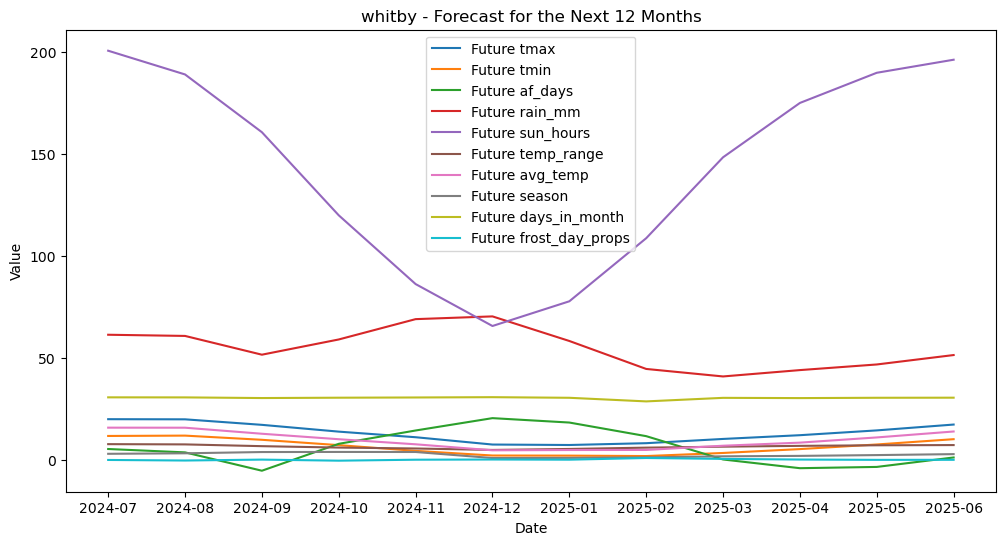

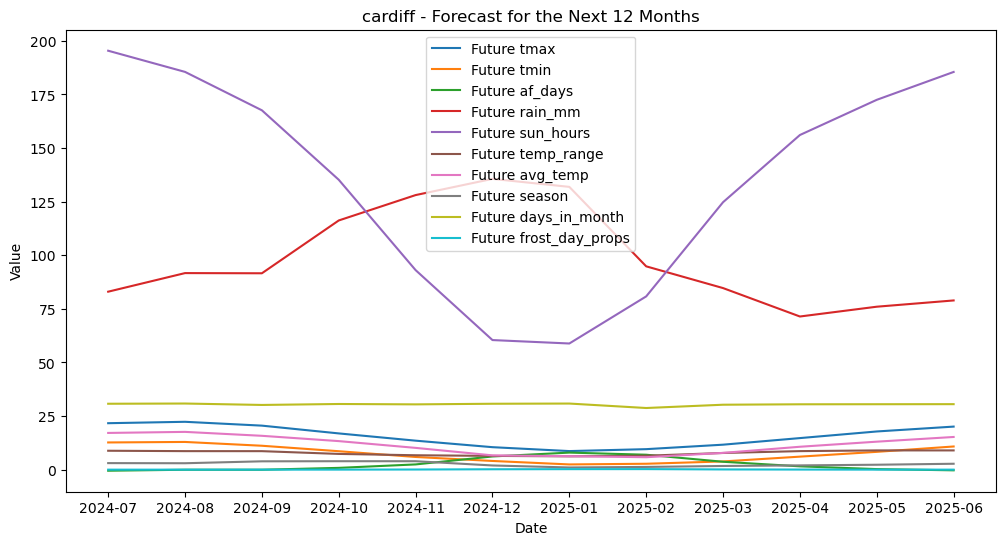

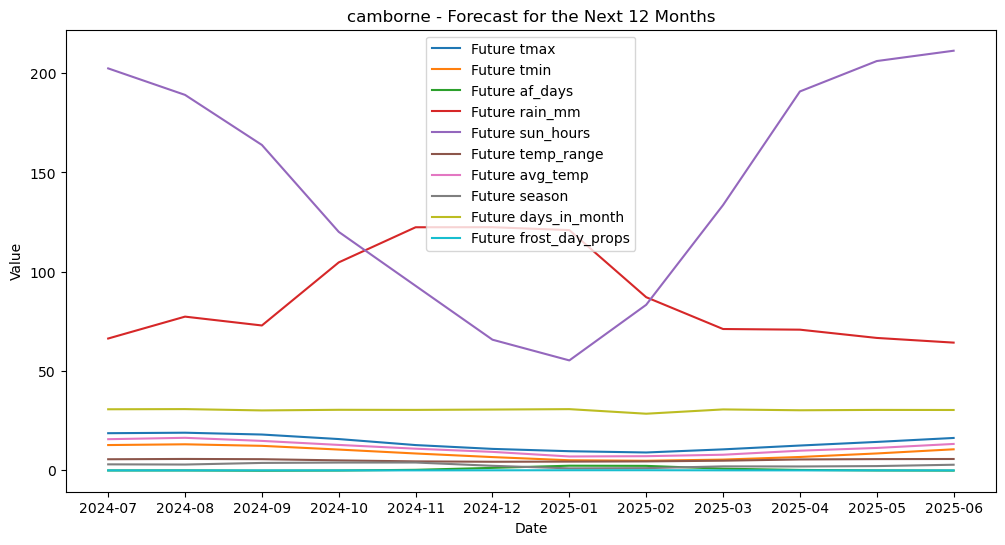

In [19]:
def plot_future_predictions(future_predictions_dict, variables):
    for station_name, future_df in future_predictions_dict.items():
        plt.figure(figsize=(12, 6))
        for variable in variables:
            plt.plot(future_df.index, future_df[variable], label=f'Future {variable}')
        
        plt.title(f"{station_name} - Forecast for the Next 12 Months")
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

# Plot future predictions
plot_future_predictions(future_predictions_dict, variables)
